In [1]:
import os
from dotenv import load_dotenv
load_dotenv()

True

In [2]:
GOOGLE_API_KEY = os.getenv("GOOGLE_API_KEY")
TAVILY_API_KEY = os.getenv("TAVILY_API_KEY")
GROQ_API_KEY = os.getenv("GROQ_API_KEY")
LANGCHAIN_API_KEY = os.getenv("LANGCHAIN_API_KEY")
LANGSMITH_PROJECT = os.getenv("LANGSMITH_PROJECT")
HUGGINGFACE_API_KEY = os.getenv("HUGGINGFACE_API_KEY")
SERPER_API_KEY = os.getenv("SERPER_API_KEY")

os.environ["GOOGLE_API_KEY"] = GOOGLE_API_KEY
os.environ["TAVILY_API_KEY"] = TAVILY_API_KEY
os.environ["GROQ_API_KEY"] = GROQ_API_KEY
os.environ["LANGCHAIN_API_KEY"] = LANGCHAIN_API_KEY
os.environ["LANGSMITH_PROJECT"] = LANGSMITH_PROJECT
os.environ["HUGGINGFACE_API_KEY"] = HUGGINGFACE_API_KEY
os.environ["SERPER_API_KEY"] = SERPER_API_KEY

In [3]:
from langchain_groq import ChatGroq

llm = ChatGroq(model_name = "llama-3.3-70b-versatile")

In [4]:
llm.invoke("I am a good boy")

AIMessage(content="That's great to hear. Being a good person is something to be proud of. What makes you think you're a good boy, and what kind of positive things have you been doing lately?", additional_kwargs={}, response_metadata={'token_usage': {'completion_tokens': 40, 'prompt_tokens': 40, 'total_tokens': 80, 'completion_time': 0.105622925, 'prompt_time': 0.010702898, 'queue_time': 0.212187128, 'total_time': 0.116325823}, 'model_name': 'llama-3.3-70b-versatile', 'system_fingerprint': 'fp_2ddfbb0da0', 'service_tier': 'on_demand', 'finish_reason': 'stop', 'logprobs': None}, id='run--70f61479-059c-44bc-9e41-905678b003f2-0', usage_metadata={'input_tokens': 40, 'output_tokens': 40, 'total_tokens': 80})

In [5]:
from langgraph.graph import StateGraph, MessagesState, START, END
from langgraph.graph.message import add_messages
from typing import Annotated, Literal, TypedDict
from langchain_core.tools import tool
from langchain_core.messages import HumanMessage
from langgraph.checkpoint.memory import MemorySaver
from langgraph.prebuilt import ToolNode

In [6]:
def call_model(state: MessagesState):
    messages = state['messages']
    response = llm.invoke(messages)
    return {"messages": [response]}

In [7]:
workflow = StateGraph(MessagesState)
workflow.add_node("chatbot", call_model)
workflow.add_edge(START, "chatbot")
workflow.add_edge("chatbot", END)
app = workflow.compile()

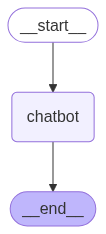

In [8]:
from IPython.display import Image, display
display(Image(app.get_graph().draw_mermaid_png()))

In [9]:
input = {"messages": ["Hi, I am Atharva"]}

In [10]:
app.invoke(input)

{'messages': [HumanMessage(content='Hi, I am Atharva', additional_kwargs={}, response_metadata={}, id='9fb16419-fb02-4e2b-99b7-0796565bc7ca'),
  AIMessage(content="Hello Atharva! It's nice to meet you. Is there something I can help you with or would you like to chat?", additional_kwargs={}, response_metadata={'token_usage': {'completion_tokens': 28, 'prompt_tokens': 42, 'total_tokens': 70, 'completion_time': 0.04565666, 'prompt_time': 0.017904484, 'queue_time': 0.213117961, 'total_time': 0.063561144}, 'model_name': 'llama-3.3-70b-versatile', 'system_fingerprint': 'fp_2ddfbb0da0', 'service_tier': 'on_demand', 'finish_reason': 'stop', 'logprobs': None}, id='run--8f97ba6a-c724-4d53-95bd-e222795b51d0-0', usage_metadata={'input_tokens': 42, 'output_tokens': 28, 'total_tokens': 70})]}

In [11]:
for output in app.stream(input):
    for key, value in output.items():
        print(f"Output from {key} node")
        print("________________________")
        print(value)
        print("\n")

Output from chatbot node
________________________
{'messages': [AIMessage(content="Hello Atharva! It's nice to meet you. Is there something I can help you with or would you like to chat?", additional_kwargs={}, response_metadata={'token_usage': {'completion_tokens': 28, 'prompt_tokens': 42, 'total_tokens': 70, 'completion_time': 0.042903994, 'prompt_time': 0.011101057, 'queue_time': 0.21287669, 'total_time': 0.054005051}, 'model_name': 'llama-3.3-70b-versatile', 'system_fingerprint': 'fp_2ddfbb0da0', 'service_tier': 'on_demand', 'finish_reason': 'stop', 'logprobs': None}, id='run--1d624c7a-ca90-462b-8468-c67bfb0f19ee-0', usage_metadata={'input_tokens': 42, 'output_tokens': 28, 'total_tokens': 70})]}




### Adding simple custom tool

In [12]:
@tool
def search(query: str):
    """ Custom Tool"""
    if "sf" in query.lower() or "san francisco" in query.lower():
        return "It is 60 degree and foogy outside."
    return "It is 90 degrees and hot outside"

In [13]:
search.invoke("What is the temperature in sf?")

'It is 60 degree and foogy outside.'

In [14]:
search.invoke("What is the weather in India")

'It is 90 degrees and hot outside'

In [15]:
tools = [search]

In [16]:
tool_node = ToolNode(tools)

In [17]:
llm_with_tool = llm.bind_tools(tools)

In [18]:
def call_model2(state: MessagesState):
    messages1 = state['messages']
    response1 = llm_with_tool.invoke(messages1)
    return {"messages": [response1]}

Now this call_model function has an updated LLM, i.e. it also has the tool functionality. So it will decide whether it needs to call the tool or it needs to call the LLM in order to answer the input question.

In [19]:
response1 = call_model2({"messages": ["Hello, I am Atharva"]})

In [20]:
messages1 = response1['messages']

In [21]:
last_message = messages1[-1]

In [22]:
last_message.tool_calls

[]

In [23]:
response = call_model2({"messages": ["What is the weather in India"]})

In [24]:
response

{'messages': [AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'ras40czvd', 'function': {'arguments': '{"query":"India weather forecast"}', 'name': 'search'}, 'type': 'function'}]}, response_metadata={'token_usage': {'completion_tokens': 15, 'prompt_tokens': 208, 'total_tokens': 223, 'completion_time': 0.049727152, 'prompt_time': 0.023348131, 'queue_time': 0.213142204, 'total_time': 0.073075283}, 'model_name': 'llama-3.3-70b-versatile', 'system_fingerprint': 'fp_3f3b593e33', 'service_tier': 'on_demand', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run--b9270587-13c2-4ecd-b449-ca61bc02b385-0', tool_calls=[{'name': 'search', 'args': {'query': 'India weather forecast'}, 'id': 'ras40czvd', 'type': 'tool_call'}], usage_metadata={'input_tokens': 208, 'output_tokens': 15, 'total_tokens': 223})]}

In [25]:
messages = response['messages']

In [26]:
last_message = messages[-1]

In [ ]:
last_message.tool_calls

[{'name': 'search',
  'args': {'query': 'India weather forecast'},
  'id': 'ras40czvd',
  'type': 'tool_call'}]

In [30]:
response = call_model2({"messages": ["What is the weather in sf?"]})

In [31]:
response

{'messages': [AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'fw6mhmx65', 'function': {'arguments': '{"query":"San Francisco weather"}', 'name': 'search'}, 'type': 'function'}]}, response_metadata={'token_usage': {'completion_tokens': 15, 'prompt_tokens': 209, 'total_tokens': 224, 'completion_time': 0.040380251, 'prompt_time': 0.024356285, 'queue_time': 0.214662361, 'total_time': 0.064736536}, 'model_name': 'llama-3.3-70b-versatile', 'system_fingerprint': 'fp_2ddfbb0da0', 'service_tier': 'on_demand', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run--d9698c43-74d3-460a-8e7e-d6b8c34d1028-0', tool_calls=[{'name': 'search', 'args': {'query': 'San Francisco weather'}, 'id': 'fw6mhmx65', 'type': 'tool_call'}], usage_metadata={'input_tokens': 209, 'output_tokens': 15, 'total_tokens': 224})]}

In [32]:
last_message = messages[-1]

In [33]:
last_message.tool_calls

[{'name': 'search',
  'args': {'query': 'India weather forecast'},
  'id': 'ras40czvd',
  'type': 'tool_call'}]